# Deep Learning With Apache Spark

Deep Learning Pipelines is an open source library created by Databricks that
provides high-level APIs for scalable deep learning in Python with Apache Spark.

It is an awesome effort and it won’t be long until is merged into the official
API, so is worth taking a look of it.

Some of the advantages of this library compared to the ones that joins Spark
with DL are:

* In the spirit of Spark and [Spark MLlib](https://spark.apache.org/mllib/), it
provides easy-to-use APIs that enable deep learning in very few lines of code.
* It focuses on ease of use and integration, without sacrificing performace.
* It’s build by the creators of Apache Spark (which are also the main
contributors) so it’s more likely for it to be merged as an official API than
others.
* It is written in Python, so it will integrate with all of its famous libraries,
and right now it uses the power of TensorFlow and Keras, the two main libraries
of the moment to do DL.

Deep Learning Pipelines builds on Apache Spark’s [ML
Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html) for training,
and with Spark DataFrames and SQL for deploying models. It includes high-level
APIs for common aspects of deep learning so they can be done efficiently in a
few lines of code:

* Image loading
* Applying pre-trained models as transformers in a Spark ML pipeline
* Transfer learning
* Applying Deep Learning models at scale
* Distributed hyperparameter tuning **(I will talk about this later)**
* Deploying models in DataFrames and SQL

I will describe each of these features in detail with examples. These examples
comes from the official
[notebook](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/5669198905533692/3647723071348946/3983381308530741/latest.html)
by Databricks.

## Apache Spark on Deep Cognition

To run and test the codes in this article you will need to create an account in
[Deep Cognition](http://deepcognition.ai/register/). 

Is very easy and then you can access all of their features. When you log in this
is what you should be seeing:

![](https://cdn-images-1.medium.com/max/2000/1*8ijqj85Tjscv9xpXjHfEFA.png)

Now just click on the left part, the Notebook button:

![](https://cdn-images-1.medium.com/max/1600/1*mnMlcYuO2U-KzRvYSuj-Cw.png)

And you will be on the Jupyter Notebook with all the installed packages :). Oh!
A note here: The Spark Notebook (DLS SPARK) is an upcoming feature which will be
released to public sometime next month and tell that it is still in private beta
(just for this post).


### Loading Spark-DL into the notebook

Until now there's no pip installation for the package so we will need to use this workaround to use it inside the notebook. After that we will start the `SparkSession` and `SparkContext`.

In [1]:
import os
SUBMIT_ARGS = "--packages databricks:spark-deep-learning:1.0.0-spark2.3-s_2.11 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("DL with Spark Deep Cognition").getOrCreate()
sc = spark.sparkContext

In [3]:
sc

<SparkContext master=local[*] appName=DL with Spark Deep Cognition>

### Image Loading

The first step to applying deep learning on images is the ability to load the
images. Deep Learning Pipelines created the utility functions that can load
millions of images into a DataFrame and decode them automatically in a
distributed fashion, allowing manipulation at scale. Now the newest version of spark
(2.3.0) has this ability too and we will be using it to load the images.

We will be using the archive of creative-commons licensed flower photos curated
by TensorFlow to test this out. To get the set of flower photos, run these
commands from the notebook (we will also create a sample folder):

In [4]:
!curl -O http://download.tensorflow.org/example_images/flower_photos.tgz
!tar xzf flower_photos.tgz
!mkdir flower_photos/sample

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  6698k      0  0:00:33  0:00:33 --:--:-- 9651k


Let’s copy some photos from the tulips and daisy folders to create a small sample of the photos. 

In [4]:
!cp flower_photos/daisy/100080576_f52e8ee070_n.jpg flower_photos/sample/
!cp flower_photos/daisy/10140303196_b88d3d6cec.jpg flower_photos/sample/
!cp flower_photos/tulips/100930342_92e8746431_n.jpg flower_photos/sample/

To take a look at these images on the notebook you can run this:

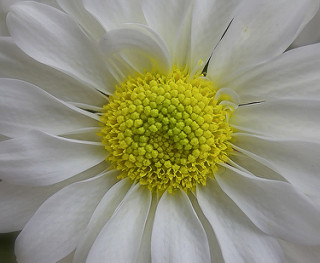

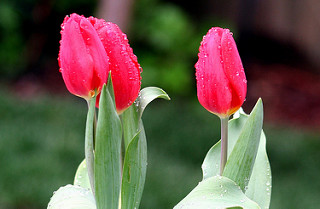

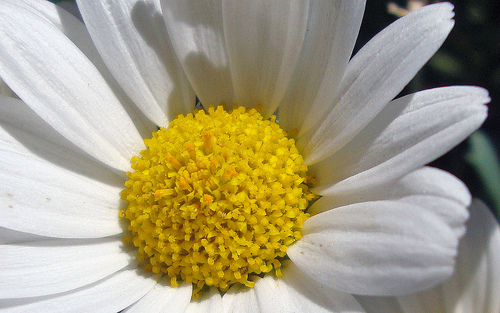

In [5]:
# collect all .png files in working dir
fs = !ls flower_photos/sample/*.jpg


import IPython.display as dp

# create list of image objects
images = []
for ea in fs:
    images.append(dp.Image(filename=ea, format='png'))

# display all images
for ea in images:
    dp.display_png(ea)

Now let’s use Spark to load this images as a DataFrame. The method `spark.readImage` lets you read images in common formats (jpg, png, etc.) from HDFS storage into DataFrame. Each image is stored as a row in the imageSchema format. The recursive option allows you to read images from subfolders, for example for positive and negative labeled samples. The sampleRatio parameter allows you to experiment with a smaller sample of images before training a model with full data.

In [10]:
from pyspark.ml.image import ImageSchema
# Read images using Spark
image_df = ImageSchema.readImages("flower_photos/sample/")

If we take a look at this dataframe we see that it spark created one column, called “image”.

In [11]:
image_df.show()

+--------------------+
|               image|
+--------------------+
|[file:/Users/favi...|
|[file:/Users/favi...|
|[file:/Users/favi...|
+--------------------+



The image column contains a string column contains an image struct with schema == ImageSchema.

### Transfer learning

![](https://cdn-images-1.medium.com/max/1600/1*6eDLqIz2sOtdI-6X87Ervg.png)

Deep Learning Pipelines provides utilities to perform [transfer
learning](https://en.wikipedia.org/wiki/Transfer_learning) on images, which is
one of the fastest (code and run-time -wise) ways to start using deep learning.
Using Deep Learning Pipelines, it can be done in just several lines of code.

Deep Learning Pipelines enables fast transfer learning with the concept of a
*Featurizer*. The following example combines the InceptionV3 model and logistic
regression in Spark to adapt InceptionV3 to our specific domain. **The
DeepImageFeaturizer automatically peels off the last layer of a pre-trained
neural network and uses the output from all the previous layers as features for
the logistic regression algorithm**. Since logistic regression is a simple and
fast algorithm, this transfer learning training can converge quickly using far
fewer images than are typically required to train a deep learning model from
ground-up.

Firstly, we need to create training & test DataFrames for transfer learning. 

In [17]:
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit
from sparkdl.image import imageIO

tulips_df = ImageSchema.readImages("flower_photos/tulips").withColumn("label", lit(1))
daisy_df = imageIO.readImagesWithCustomFn("flower_photos/daisy", decode_f=imageIO.PIL_decode).withColumn("label", lit(0))
tulips_train, tulips_test, _ = tulips_df.randomSplit([0.1, 0.05, 0.85])  # use larger training sets (e.g. [0.6, 0.4] for getting more images)
daisy_train, daisy_test, _ = daisy_df.randomSplit([0.1, 0.05, 0.85])     # use larger training sets (e.g. [0.6, 0.4] for getting more images)
train_df = tulips_train.unionAll(daisy_train)
test_df = tulips_test.unionAll(daisy_test)

# Under the hood, each of the partitions is fully loaded in memory, which may be expensive.
# This ensure that each of the paritions has a small size.
train_df = train_df.repartition(100)
test_df = test_df.repartition(100)

And now let’s train the model

In [19]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer 

featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")
lr = LogisticRegression(maxIter=10, regParam=0.05, elasticNetParam=0.3, labelCol="label")
p = Pipeline(stages=[featurizer, lr])

p_model = p.fit(train_df)

Let’s see how well the model does:

In [20]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

tested_df = p_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(tested_df.select("prediction", "label"))))

Test set accuracy = 0.9753086419753086


Not so bad for an example and with no tunning at all!

We can take look at where we are making mistakes:

In [23]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import expr
from pyspark.sql.functions import *
from pyspark.sql.types import *

def _p1(v):
    return float(v.array[1])
take_one = udf(_p1, DoubleType())

df = tested_df.withColumn("p", take_one(tested_df.probability))
wrong_df = df.orderBy(expr("abs(p - label)"), ascending=False)
wrong_df.select("image.origin", "p", "label").show(10)

+--------------------+-------------------+-----+
|              origin|                  p|label|
+--------------------+-------------------+-----+
|file:/Users/favio...| 0.6765519606599172|    0|
|file:/Users/favio...| 0.6488288065425233|    0|
|file:/Users/favio...| 0.2990478006959378|    0|
|file:/Users/favio...|0.24766667971694895|    0|
|file:/Users/favio...|0.20110581819745543|    0|
|file:/Users/favio...|  0.829475249733301|    1|
|file:/Users/favio...| 0.8513949370932291|    1|
|file:/Users/favio...|0.13291511982428988|    0|
|file:/Users/favio...| 0.1311275271810219|    0|
|file:/Users/favio...|0.12805711589185384|    0|
+--------------------+-------------------+-----+
only showing top 10 rows



#### Applying Deep Learning models at scale

Deep Learning Pipelines supports running pre-trained models in a distributed
manner with Spark, available in both batch and [streaming data
processing](https://databricks.com/blog/2016/07/28/structured-streaming-in-apache-spark.html).


It houses some of the most popular models, enabling users to start using deep
learning without the costly step of training a model. The predictions of the
model, of course, is done in parallel with all the benefits that come with
Spark.

In addition to using the built-in models, users can plug in [Keras
models](https://keras.io/models/about-keras-models/) and TensorFlow Graphs in a
Spark prediction pipeline. This turns any single-node models on single-node
tools into one that can be applied in a distributed fashion, on a large amount
of data.

The following code creates a Spark prediction pipeline using InceptionV3, a
state-of-the-art convolutional neural network (CNN) model for image
classification, and predicts what objects are in the images that we just loaded.

In [25]:
from sparkdl import DeepImagePredictor
# Read images using Spark
image_df = ImageSchema.readImages("flower_photos/sample/")

predictor = DeepImagePredictor(inputCol="image", outputCol="predicted_labels", modelName="InceptionV3", decodePredictions=True, topK=10)
predictions_df = predictor.transform(image_df)

INFO:tensorflow:Froze 378 variables.
Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


Let's take a look to the predictions dataframe:

In [27]:
predictions_df.select("predicted_labels").show(truncate=False,n=3)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|predicted_labels                                                                                                                                                                                                                                                                                                                                                        |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Notice that the `predicted_labels` column shows "daisy" as a high probability
class for all of sample flowers using this base model,** for some reason the
tulip was closer to a picket fence than to a flower (maybe because of the
background of the photo)**. 

However, as can be seen from the differences in the probability values, the
neural network has the information to discern the two flower types. Hence our
transfer learning example above was able to properly learn the differences
between daisies and tulips starting from the base model.

Let’s see how well our model discern the type of the flower:

In [28]:
df = p_model.transform(image_df)

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [83]:
def _p1(v):
    return float(v.array[1])
take_one = udf(_p1, DoubleType())

In [30]:
# 100930342_92e8746431_n.jpg not a daisy
df.select("image.origin",(1-take_one(df.probability)).alias("p_daisy")).show(truncate=False)

+--------------------------------------------------------------------------------+--------------------+
|origin                                                                          |p_daisy             |
+--------------------------------------------------------------------------------+--------------------+
|file:/Users/faviovazquez/SparkDL/flower_photos/sample/100930342_92e8746431_n.jpg|0.016760347798379538|
|file:/Users/faviovazquez/SparkDL/flower_photos/sample/10140303196_b88d3d6cec.jpg|0.9704259547739851  |
|file:/Users/faviovazquez/SparkDL/flower_photos/sample/100080576_f52e8ee070_n.jpg|0.9705190124824862  |
+--------------------------------------------------------------------------------+--------------------+



## For Keras users

For applying Keras models in a distributed manner using Spark, KerasImageFileTransformer works on TensorFlow-backed Keras models. It 

- Internally creates a DataFrame containing a column of images by applying the user-specified image loading and processing function to the input DataFrame containing a column of image URIs
- Loads a Keras model from the given model file path
- Applies the model to the image DataFrame

To use the transformer, we first need to have a Keras model stored as a file. For this notebook we'll just save the Keras built-in InceptionV3 model instead of training one.

In [31]:
from keras.applications import InceptionV3

model = InceptionV3(weights="imagenet")
model.save('model-full.h5')  # saves to the local filesystem

Now we will create a Keras transformer but first we will preprocess the images to work with it

In [32]:
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
from pyspark.sql.types import StringType
from sparkdl import KerasImageFileTransformer

def loadAndPreprocessKerasInceptionV3(uri):
  # this is a typical way to load and prep images in keras
    image = img_to_array(load_img(uri, target_size=(299, 299)))  # image dimensions for InceptionV3
    image = np.expand_dims(image, axis=0)
    return preprocess_input(image)

transformer = KerasImageFileTransformer(inputCol="uri", outputCol="predictions",
                                        modelFile='model-full.h5',  # local file path for model
                                        imageLoader=loadAndPreprocessKerasInceptionV3,
                                        outputMode="vector")

We will read now the images and load them into a Spark Dataframe and them use our transformer to apply the model into the images:

In [33]:
fs = !ls flower_photos/sample/*.jpg

In [34]:
fs

['flower_photos/sample/100080576_f52e8ee070_n.jpg',
 'flower_photos/sample/100930342_92e8746431_n.jpg',
 'flower_photos/sample/10140303196_b88d3d6cec.jpg']

In [35]:
uri_df = spark.createDataFrame(fs, StringType()).toDF("uri")

In [36]:
uri_df.show()

+--------------------+
|                 uri|
+--------------------+
|flower_photos/sam...|
|flower_photos/sam...|
|flower_photos/sam...|
+--------------------+



In [37]:
keras_pred_df = transformer.transform(uri_df)

/Users/faviovazquez/anaconda/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


INFO:tensorflow:Froze 378 variables.
Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In [38]:
keras_pred_df.select("uri", "predictions").show()

+--------------------+--------------------+
|                 uri|         predictions|
+--------------------+--------------------+
|flower_photos/sam...|[7.43818964110687...|
|flower_photos/sam...|[3.56566015398129...|
|flower_photos/sam...|[3.49412839568685...|
+--------------------+--------------------+



### Working with general tensors

Deep Learning Pipelines also provides ways to apply models with tensor inputs
(up to 2 dimensions), written in popular deep learning libraries:

* TensorFlow graphs
* Keras models

In this article we will focus only in the Keras models. The `KerasTransformer`
applies a TensorFlow-backed Keras model to tensor inputs of up to 2 dimensions.
It loads a Keras model from a given model file path and applies the model to a
column of arrays (where an array corresponds to a Tensor), outputting a column
of arrays.

In [41]:
from sparkdl import KerasTransformer
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# Generate random input data
num_features = 10
num_examples = 100
input_data = [{"features" : np.random.randn(num_features).astype(float).tolist()} for i in range(num_examples)]
schema = StructType([ StructField("features", ArrayType(FloatType()), True)])
input_df = spark.createDataFrame(input_data, schema)

# Create and save a single-hidden-layer Keras model for binary classification
# NOTE: In a typical workflow, we'd train the model before exporting it to disk,
# but we skip that step here for brevity
model = Sequential()
model.add(Dense(units=20, input_shape=[num_features], activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model_path = "simple-binary-classification"
model.save(model_path)

# Create transformer and apply it to our input data
transformer = KerasTransformer(inputCol="features", outputCol="predictions", modelFile=model_path)
final_df = transformer.transform(input_df)

INFO:tensorflow:Froze 4 variables.
Converted 4 variables to const ops.
INFO:tensorflow:Froze 0 variables.


/Users/faviovazquez/anaconda/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Converted 0 variables to const ops.


In [46]:
final_df.show()

+-------------+--------------------+
|  predictions|            features|
+-------------+--------------------+
| [0.86104786]|[-0.76344526, 0.2...|
| [0.21693115]|[0.41084298, 0.93...|
|[0.057743043]|[0.062970825, 0.3...|
| [0.43409333]|[-0.43408343, -1....|
| [0.43690935]|[-0.89413625, 0.8...|
| [0.49984664]|[-0.82052463, -0....|
|  [0.6204273]|[-0.5075533, 0.54...|
|  [0.2285336]|[0.016106872, -0....|
| [0.37478408]|[-1.6756374, 0.84...|
|  [0.2997861]|[-0.34952268, 1.2...|
|  [0.3885377]|[0.1639214, -0.22...|
|  [0.5006814]|[0.91551965, -0.3...|
| [0.20518135]|[-1.2620118, -0.4...|
| [0.18882117]|[-0.14812712, 0.8...|
| [0.49993372]|[1.4617485, -0.33...|
| [0.42390883]|[-0.877813, 0.603...|
|  [0.5232896]|[-0.031451378, -1...|
| [0.45858437]|[0.9310042, -1.77...|
| [0.49794272]|[-0.37061003, -1....|
|  [0.2543479]|[0.41954428, 1.88...|
+-------------+--------------------+
only showing top 20 rows



### Deploying Models in SQL

One way to productionize a model is to deploy it as a Spark SQL User Defined Function, which allows anyone who knows SQL to use it. Deep Learning Pipelines provides mechanisms to take a deep learning model and register a Spark SQL User Defined Function (UDF). In particular, Deep Learning Pipelines 0.2.0 adds support for creating SQL UDFs from Keras models that work on image data.

The resulting UDF takes a column (formatted as a image struct “SpImage”) and produces the output of the given Keras model; e.g. for Inception V3, it produces a real valued score vector over the ImageNet object categories.

In [47]:
from keras.applications import InceptionV3
from sparkdl.udf.keras_image_model import registerKerasImageUDF

registerKerasImageUDF("inceptionV3_udf", InceptionV3(weights="imagenet"))

INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


/Users/faviovazquez/anaconda/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


INFO:tensorflow:Froze 378 variables.
Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In Keras workflows dealing with images, it’s common to have preprocessing steps before the model is applied to the image. If our workflow requires preprocessing, we can optionally provide a preprocessing function to UDF registration. The preprocessor should take in a filepath and return an image array; below is a simple example.

In [53]:
from keras.applications import InceptionV3
from sparkdl.udf.keras_image_model import registerKerasImageUDF

def keras_load_img(fpath):
    from keras.preprocessing.image import load_img, img_to_array
    import numpy as np
    img = load_img(fpath, target_size=(299, 299))
    return img_to_array(img).astype(np.uint8)

registerKerasImageUDF("inceptionV3_udf_with_preprocessing", InceptionV3(weights="imagenet"), keras_load_img)

INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


/Users/faviovazquez/anaconda/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


INFO:tensorflow:Froze 378 variables.
Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


Once a UDF has been registered, it can be used in a SQL query:

In [48]:
from pyspark.ml.image import ImageSchema

image_df = ImageSchema.readImages("flower_photos/sample/")
image_df.registerTempTable("sample_images")

In [49]:
image_df.show()

+--------------------+
|               image|
+--------------------+
|[file:/Users/favi...|
|[file:/Users/favi...|
|[file:/Users/favi...|
+--------------------+



In [54]:
spark.sql("SELECT inceptionV3_udf_with_preprocessing(image) as predictions from sample_images").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

This is very powerful. Once a data scientist builds the desired model, Deep Learning Pipelines makes it simple to expose it as a function in SQL, so anyone in their organization can use it — data engineers, data scientists, business analysts, anybody.

In the next part I’ll discuss Distributed Hyperparameter Tuning with Spark, and
will try new models and examples :).